In [ ]:
import os
if not os.path.exists("/usr/local/lib/python3.11/dist-packages/anvil"):
    !pip install anvil-uplink
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import liobraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 300

In [ ]:
#load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/My Drive/Praktikum Pola/dataset3',
        shuffle=True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 2000 files belonging to 4 classes.


In [ ]:
import tensorflow as tf

dataset_path = "/content/drive/My Drive/Praktikum Pola/dataset3"  # ganti dengan path folder dataset kamu

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # sesuaikan ukuran dengan model kamu
    batch_size=32
)

# Mendapatkan nama-nama kelas
class_names = train_ds.class_names
print("Nama kelas yang ditemukan dalam dataset:")
print(class_names)


Found 2000 files belonging to 4 classes.
Nama kelas yang ditemukan dalam dataset:
['_BrownSpot', '_Healthy', '_Hispa', '_LeafBlast']


In [ ]:
class_names = dataset.class_names

In [ ]:
len(dataset)

63

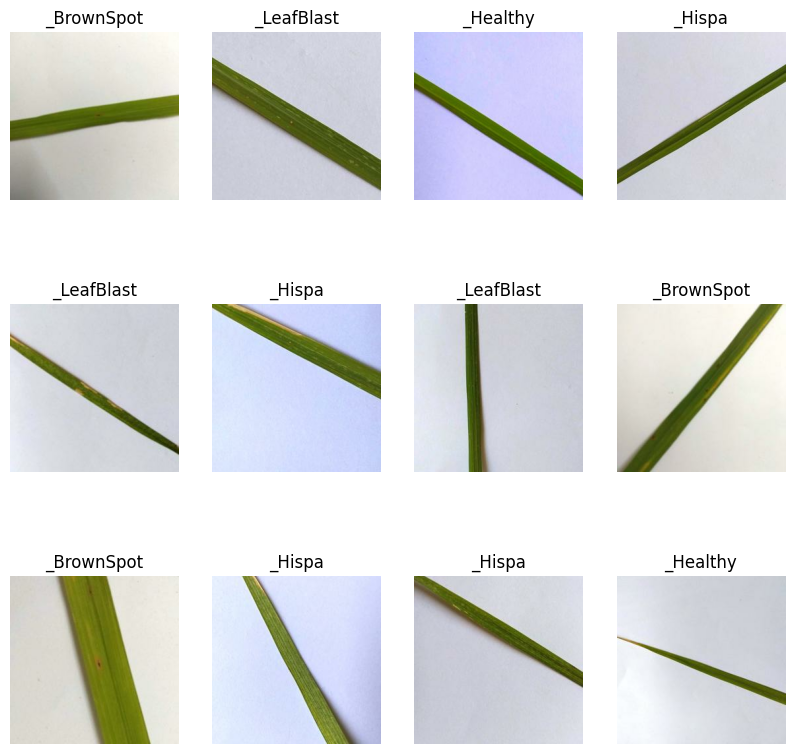

In [ ]:
#exploring a single batch
plt.figure(figsize=(10,10)) #increase image area to 10x10
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])#display title
        plt.axis("off")
        #print(image_batch[0].shape)#exploration
        #print(label_batch.numpy())#covert to numpy

In [ ]:
#split dataset in function
def get_dataset_partition_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds) #dataset size
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size) #train size converted to intger to avoid float
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
len(train_ds)

50

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

7

In [ ]:
#cache will read image from disk and keep image in memeory for next iteration.
#prefetch and cache to optimize our input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #buffer_size=tf.data.AUTOTUNE is to allow tf determine the batch size
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#resize and rescale
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
#data_augmentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #google Conv2D for all arguement. 32=no. of layers
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #flatten into an array of neurons
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'), #softmax normalizes the prob of classes.
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] #track training process
)

In [ ]:
#good to record the history of every epochs in params
history = model.fit(
    train_ds,
    epochs=15,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.2819 - loss: 1.3886 - val_accuracy: 0.4635 - val_loss: 1.3700
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.3372 - loss: 1.3277 - val_accuracy: 0.4219 - val_loss: 1.1963
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.4420 - loss: 1.1653 - val_accuracy: 0.4844 - val_loss: 1.0282
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.4948 - loss: 1.0437 - val_accuracy: 0.5312 - val_loss: 0.9964
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.4730 - loss: 1.0581 - val_accuracy: 0.5573 - val_loss: 0.9790
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.5067 - loss: 1.0283 - val_accuracy: 0.5104 - val_loss: 1.0428
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.4508 - loss: 1.1162 - val_accuracy: 0.5521 - val_loss: 0.9547
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.5391 - loss: 0.9719 - val_accuracy: 0.5365 - v

In [ ]:
#test model with test_ds
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5316 - loss: 0.9821


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 50}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.31439393758773804,
 0.41287878155708313,
 0.40909090638160706,
 0.3970959484577179,
 0.46148988604545593,
 0.4905303120613098,
 0.46338382363319397,
 0.4835858643054962,
 0.5265151262283325,
 0.556186854839325,
 0.5410353541374207,
 0.5492424368858337,
 0.5782828330993652,
 0.45643940567970276,
 0.501893937587738]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

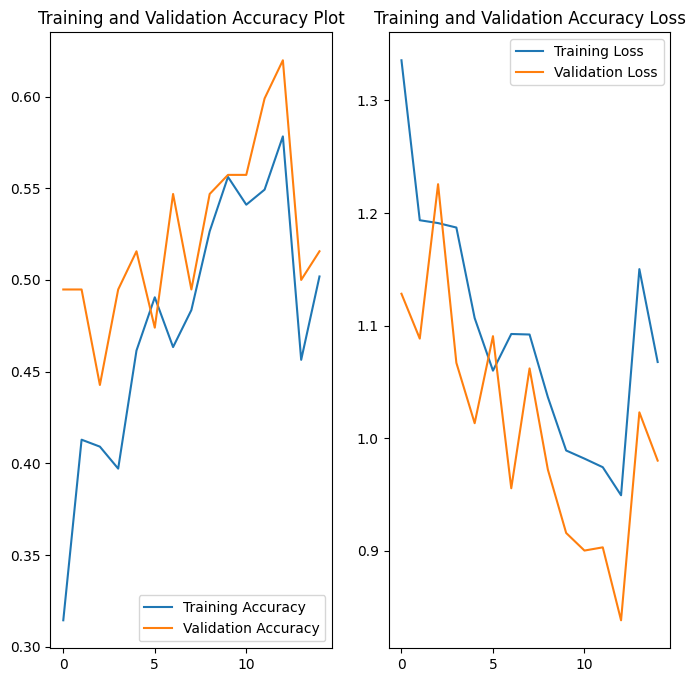

In [ ]:
#plotting training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(15), acc, label = 'Training Accuracy')
plt.plot(range(15), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(range(15), loss, label = 'Training Loss')
plt.plot(range(15), val_loss, label ='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.show()

In [ ]:
history.history['val_accuracy']

[0.4947916567325592,
 0.4947916567325592,
 0.4427083432674408,
 0.4947916567325592,
 0.515625,
 0.4739583432674408,
 0.546875,
 0.4947916567325592,
 0.546875,
 0.5572916865348816,
 0.5572916865348816,
 0.5989583134651184,
 0.6197916865348816,
 0.5,
 0.515625]

In [ ]:
np.argmax([0.04980154,0.5683826,0.2425103,0.13930552])

np.int64(1)

first image to predict
actual label: _BrownSpot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
prediction:  _BrownSpot


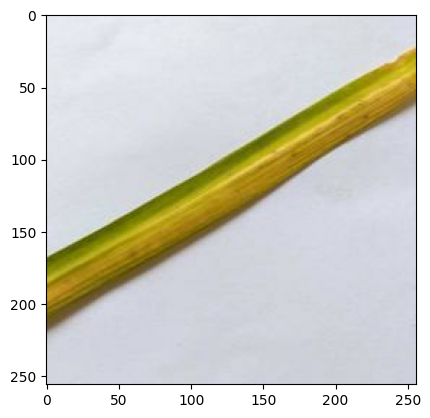

In [ ]:
#make a prediction - 1 batch - test_ds

for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy().astype('uint8'))
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    #model is ready so call predict function
    batch_prediction = model.predict(images_batch)
    print("prediction: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

# Daftar nama kelas sesuai model kamu
class_names = ['_Brownspot', '_Healthy', '_Hispa', '_LeafBlast']  # Sesuaikan!

# Ukuran input model
img_height = 224
img_width = 224

# Fungsi prediksi
def predict_uploaded_image(uploaded_file):
    img = Image.open(io.BytesIO(uploaded_file)).convert('RGB')
    img_resized = img.resize((img_width, img_height))

    img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.show()

    print("Prediction:", predicted_class)
    print("Confidence:", confidence, "%")

# Fungsi saat upload berubah
def on_upload_change(change):
    for name, file_info in upload_widget.value.items():
        predict_uploaded_image(file_info['content'])

# Widget upload
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')

display(widgets.HTML("<h3>Upload gambar daun padi</h3>"))
display(upload_widget)


HTML(value='<h3>Upload gambar daun padi</h3>')

FileUpload(value={}, accept='image/*', description='Upload')

In [ ]:
#prediction class vs confidence
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


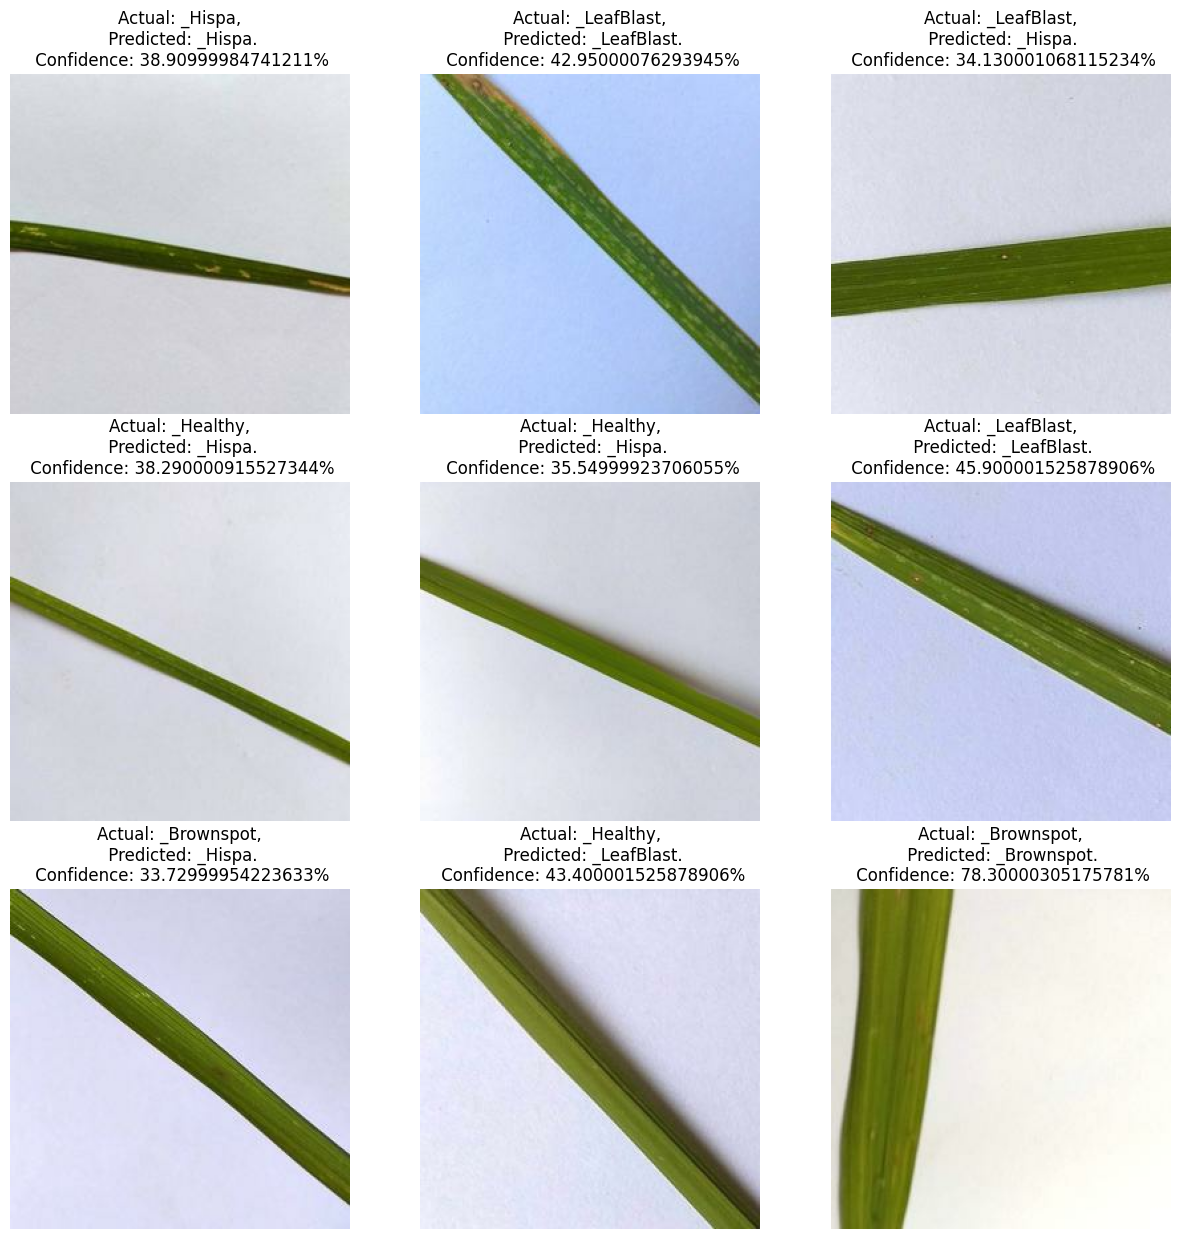

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") #using python format string

        plt.axis("off")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

# --- Daftar kelas ---
class_names = ['_Brownspot', '_Healthy', '_Hispa', '_LeafBlast']  # Contoh, sesuaikan!

# --- Fungsi prediksi ---
def predict(model, img):
    img = img.resize((img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Buat batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# --- Fungsi untuk menampilkan prediksi dari gambar upload ---
def on_upload_change(change):
    for name, file_info in upload_widget.value.items():
        img = Image.open(io.BytesIO(file_info['content'])).convert('RGB')

        predicted_class, confidence = predict(model, img)

        # Tampilkan gambar dan hasil
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
        plt.show()

# --- Ukuran gambar yang diharapkan oleh model ---
img_height = 224
img_width = 224

# --- Buat widget upload file ---
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')

# --- Tampilkan widget ---
display(widgets.HTML(value="<h3>Upload Gambar Daun Padi</h3>"))
display(upload_widget)


HTML(value='<h3>Upload Gambar Daun Padi</h3>')

FileUpload(value={}, accept='image/*', description='Upload')

In [ ]:
# model_version = 1
model.save(f"rice_models.h5")

In [ ]:
import anvil.server
import anvil.media
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Hubungkan ke Anvil
anvil.server.connect("server_R7N6M7JBJD27XUGQKKCOQLRS-TYQTVSNSSXADKHHI")

# Load model
model = load_model("/content/rice_models.h5")

# Daftar nama kelas (urutannya HARUS sesuai dengan saat training)
class_names = ['Bercak Coklat', 'Sehat', 'Jamur', 'Hawar Daun']

@anvil.server.callable
def klasifikasi_gambar(file):
    # Baca file dari Anvil ke path lokal
    with anvil.media.TempFile(file) as file_path:
        # Buka gambar dan sesuaikan ukuran
        image = Image.open(file_path).convert('RGB')
        image = image.resize((224, 224))

        # Ubah ke array dan siapkan input batch
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)  # shape: (1, 224, 224, 3)
        img_array = img_array / 255.0  # normalisasi (pastikan ini sesuai saat training)

        # Prediksi
        predictions = model.predict(img_array)
        predicted_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_index]
        confidence = round(100 * np.max(predictions[0]), 2)

        # Penjelasan tiap penyakit (opsional)
        deskripsi = {
            "Bercak Coklat": "Penyakit oleh jamur Helminthosporium oryzae, menimbulkan bercak coklat pada daun.",
            "Sehat": "Daun tidak menunjukkan gejala penyakit.",
            "Jamur": "Daun terinfeksi jamur, biasanya menunjukkan bintik atau warna tidak merata.",
            "Hawar Daun": "Disebabkan oleh bakteri Xanthomonas oryzae, ditandai dengan warna kuning kecoklatan menyebar dari ujung daun."
        }

        return {
            "kelas": predicted_class,
            "confidence": confidence,
            "deskripsi": deskripsi.get(predicted_class, "")
        }

print("Model dan server Anvil siap.")
anvil.server.wait_forever()


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


Model dan server Anvil siap.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
